In [4]:
import numpy as np
import glob
import json
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

from imgaug import augmenters as iaa
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

from augmentation import *
from model import default_categorical
from utils import linear_bin, tub_to_array, rebalance

In [41]:
# AVAILABLE TUBS
tub_20181113_42_afternoon = '/home/data/tortue-rapide/tubs/raw/tub_20181113_42_afternoon'
tub_20181113_42_evening = '/home/data/tortue-rapide/tubs/raw/tub_20181113_42_evening'
tub_20181124_morning_lesquare_horaire = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_horaire'
tub_20181124_morning_lesquare_antihoraire = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_antihoraire'
tub_20181122_ysance_noon = '/home/data/tortue-rapide/tubs/raw/tub_20181122_ysance_noon'

# EXAMPLES
img_example = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/291_cam-image_array_.jpg'
json_exple = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/record_291.json'

save_model_path = '/home/projects/tortue-rapide/franklin_gym/test_models'

# convert tubs to numpy arrays
x_42_afternoon, y_42_afternoon = tub_to_array(tub_20181113_42_afternoon, n_class=3)
x_42_evening, y_42_evening = tub_to_array(tub_20181113_42_evening, n_class=3)
x_morning_lesquare_horaire, y_morning_lesquare_horaire = tub_to_array(tub_20181124_morning_lesquare_horaire, n_class=3)
x_morning_lesquare_antihoraire, y_morning_lesquare_antihoraire = tub_to_array(tub_20181124_morning_lesquare_antihoraire, n_class=3)
X_ysance_noon, Y_ysance_noon = tub_to_array(tub_20181122_ysance_noon, n_class=3)

# rebalance ecole 42 tubs  classes
x_42_afternoon, y_42_afternoon = rebalance(x_42_afternoon, y_42_afternoon)
x_42_evening, y_42_evening = rebalance(x_42_evening, y_42_evening)
x_morning_lesquare_horaire, y_morning_lesquare_horaire = rebalance(x_morning_lesquare_horaire, y_morning_lesquare_horaire)

# train / validation split
X_train = np.concatenate((x_42_afternoon, x_morning_lesquare_antihoraire, x_morning_lesquare_horaire))
Y_train = np.concatenate((y_42_afternoon, y_morning_lesquare_antihoraire, y_morning_lesquare_horaire)) 
X_val, Y_val = X_ysance_noon[:20000], Y_ysance_noon[:20000]

In [44]:
len(X_train), len(X_val)

(10000, 5114)

In [18]:
a = np.array([1, 2, 3])

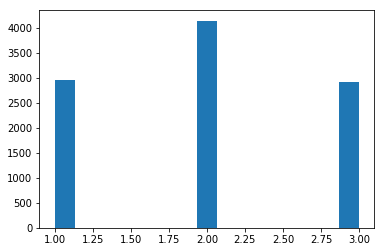

In [43]:
import matplotlib.pyplot as plt

def plot_hist(Y):
    '''
    Y : categorical numpy array'''
    fi = [sum(n * a) for n in Y]
    plt.hist(fi, bins='auto')

plot_hist(Y_train)

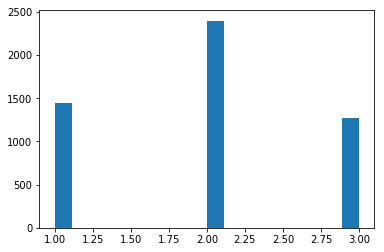

In [42]:
plot_hist(Y_val)

In [2]:
# MAP DATA PREPARATION

train_tubs = ['tub_20181113_42_afternoon', 
              'tub_20181113_42_evening',
              'tub_20181124_morning_lesquare_antihoraire']
validation_tubs = ['tub_20181122_ysance_noon']

rebalance_tubs = ['tub_20181113_42_afternoon', 
                  'tub_20181113_42_evening']

# 'tweak_luminosity'
# 'add_snow'
# 'add_shadow'
# 'add_blur'
# 'add_gaussian_noise'
# 'random_shadows'
# 'generate_night_effect' 
# 'generate_brightness'
# 'generate_contrast_normalization'
augmentation_functions = ['tweak_luminosity', 'generate_contrast_normalization']

PROPORTION = 0.1

In [48]:
print('{} samples'.format(len(X_train)))

for augment in augmentation_functions:
    if augment in transform_dict.keys():
        print(augment)
        f = transform_dict[augment]
        X_transfo, Y_transfo = transform(X_train, Y_train, transformation=f, proportion=PROPORTION)
        X_train = np.concatenate((X_train, X_transfo))
        Y_train = np.concatenate((Y_train, Y_transfo)) 
        

print('{} samples'.format(len(X_train)))

 21%|██        | 251/1210 [00:00<00:00, 2505.63it/s]

12100 samples
tweak_luminosity


100%|██████████| 1210/1210 [00:00<00:00, 2917.45it/s]


13310 samples


In [11]:
len(X_train)

7965

In [220]:
image_ori = np.concatenate((image_ori, image_HLS))

In [221]:
image_ori.shape

(125, 120, 160, 3)

In [ ]:
bight_x_train_5eme, bright_y_train_5eme = aug.generate_brightness(X_train, Y_train)
bight_x_train_5eme, bright_y_train_5eme = aug.generate_night_effect(X_train, Y_train)
bight_x_train_5eme, bright_y_train_5eme = aug.generate_random_shadows(X_train, Y_train)

In [ ]:
# fit model

epochs=100
steps=100
verbose=1
min_delta=.0005
patience=5
use_early_stop=True


model = default_categorical()

# checkpoint to save model after each epoch
save_best = ModelCheckpoint(save_model_path,
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

callbacks_list = [save_best]

if use_early_stop:
    callbacks_list.append(early_stop)

model.summary()
    
# fit from numpy array
hist = model.fit(x=X_train,
                 y=Y_train,
                 steps_per_epoch=steps,
                 epochs=epochs,
                 verbose=1,
                 validation_data=(X_val, Y_val),
                 callbacks=callbacks_list,
                 validation_steps=200/8)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 78, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 37, 32)        19232     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 17, 64)         51264     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 8, 64)          36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 6, 64)          36928     
__________

Structure:
- import data
- train (3 tubs) / test (1 different tub) split
- apply data augmentations
- train + validate

Interface
testor.benchmark([['processing1', 'processing2'], 
                  ['processing4', 'processing2', 'processing5']])
                  
generate_brightness
generate_night_effect
generate_random_shadows

In [6]:
%%bash 
pip install --upgrade pip

Looking in indexes: https://rec-nexus.dmp.y-track.com/repository/pypi-all/simple
  Using cached https://rec-nexus.dmp.y-track.com/repository/pypi-all/packages/d8/f3/413bab4ff08e1fc4828dfc59996d721917df8e8583ea85385d51125dceff/pip-19.0.3-py2.py3-none-any.whl
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1


In [4]:

def tweak_luminosity(image):
    image_HLS = cv2.cvtColor(image, cv2.COLOR_BGR2HLS) ## Conversion to HLS
    random_brightness_coefficient = np.random.uniform()+0.5 ## generates value between 0.5 and 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB)
    return image_RGB

def add_snow(image):
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    brightness_coefficient = 2.5 
    snow_point=60 ## increase this for more snow
    image_HLS[:,:,1][image_HLS[:,:,1]<snow_point] = image_HLS[:,:,1][image_HLS[:,:,1]<snow_point]*brightness_coefficient ## scale pixel values up for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def shadow_coordinates(imshape, no_of_shadows=2):
    vertices_list=[]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices


def add_shadows(image, no_of_shadows=2):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list = shadow_coordinates(imshape, no_of_shadows) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def add_blur(images):
    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
    ])
    
    aug_images = seq.augment_images(image_ori)
    
    return aug_images

def add_gaussian_noise(images):
    seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=(0, 0.08*255))
    ])
    
    aug_images = seq.augment_images(image_ori)
    
    return aug_images


def add_contrast_normalization(images):
    seq = iaa.Sequential([
        iaa.ContrastNormalization((0.2, 1.5))
    ])
    
    aug_images = seq.augment_images(image_ori)
    
    return aug_images


def transform(X, Y, transformation, proportion=0.25):
    # Generate a random selection of indexes
    indexes = random.sample(range(0, X.shape[0]), int(X.shape[0]*proportion))
    
    X_aug = []
    Y_aug = []
    for index in tqdm(indexes):
        im = transformation(X[index])
        X_aug.append(im)
        Y_aug.append(Y[index])

    return np.asarray(X_aug), np.asarray(Y_aug)

# augmentation dict
transform_dict = {
    'tweak_luminosity': tweak_luminosity,
    'add_snow': add_snow,
    'add_shadow': add_shadow,
    'add_blur': add_blur,
    'add_gaussian_noise': add_gaussian_noise,
    'add_shadows': add_shadows,
    'add_contrast_normalization': add_contrast_normalization
}
